<!--<badge>--><a href="https://colab.research.google.com/github/huggingface/workshops/blob/main/fewshot-learning-in-production/setfit-optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

# Efficently run SetFit Models with Optimum

[SetFit](https://github.com/huggingface/setfit) is a technique for few-shot text classification that uses contrastive learning to fine-tune Sentence Transformers in domains where little to no labeled data is available. It achieves comparable performance to existing state-of-the-art methods based on large language models, yet requires no prompts and is efficient to train (typically a few seconds on a GPU to minutes on a CPU).

In this notebook you'll learn how to further compress SetFit models for faster inference & deployment on GPU using Optimum Onnx.

## 1. Setup development environment

Our first step is to install SetFit. Running the following cell will install all the required packages for us.

In [ ]:
!pip install setfit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.2 MB/s

While we're at it, let's turn off some of the warnings from the 🤗 Datasets library and the tokenizers:

In [ ]:
import datasets

datasets.logging.set_verbosity_error()

%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


To be able to share your model with the community, there are a few more steps to follow.

First, you have to store your authentication token from the Hugging Face Hub (sign up here if you haven't already!). To do so, execute the following cell and input an **access token with write permissions** associated with your account:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## 2. Create a performance benchmark

Before we train and optimize any models, let's define a performance benchmark that we can use to compare our models. In general, deploying ML models in production environments involves a tradeoff among several constraints:

* Model performance: how well does the model perform on a well crafted test set?
* Latency: how fast can our model deliver predictions?
* Memory: on what cloud instance or device can we store and load our model?

The class below defines a simplebenchmark that measure each quantity for a given SetFit model and test dataset:

In [ ]:
from pathlib import Path
from time import perf_counter

import evaluate
import numpy as np
import torch
from tqdm.auto import tqdm

metric = evaluate.load("accuracy")


class PerformanceBenchmark:
    def __init__(self, model, dataset, optim_type):
        self.model = model
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        preds = self.model.predict(self.dataset["text"])
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

    def compute_size(self):
        state_dict = self.model.model_body.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    #def time_model(self, query="the story of trouble every day ... is so sketchy it amounts to little more than preliminary notes for a science-fiction horror film , and the movie 's fragmentary narrative style makes piecing the story together frustrating difficult."):
    def time_model(self, query="that loves its characters and communicates something rather beautiful about human nature"):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.model([query])
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.model([query])
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.compute_accuracy())
        metrics[self.optim_type].update(self.time_model())
        return metrics

## 3. Train/Eval bge-small SetFit models

Before we optimize any models, let's train a few baselines as a point of reference. We'll use the [sst-2](https://huggingface.co/datasets/SetFit/sst2) dataset, which is a collection of sentiment text catagorized into 2 classes: positive, negative

Let's start by loading the dataset from the Hub:

In [ ]:
from datasets import load_dataset

dataset = load_dataset("SetFit/sst2")
dataset

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1821
    })
})

We train SetFit with the full dataset. Recall that SetFit excales with few-shot scenario but this time we are interested to achieve maximum accuracy.

In [ ]:
from setfit import sample_dataset

train_dataset = dataset["train"]
test_dataset = dataset["validation"]

Use the following line code to upload the model and evaluate or remask the following code section for fine-tuning the base model from scratch.

In [ ]:
# Evaluate the uploaded model!
from setfit import SetFitModel, SetFitTrainer
small_model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
pb = PerformanceBenchmark(model=small_model, dataset=test_dataset, optim_type="bge-small PyTorch"
)
perf_metrics = pb.run_benchmark()

Model size (MB) - 127.33
Accuracy on test set - 0.906
Average latency (ms) - 13.71 +\- 0.91


In [ ]:
perf_metrics

{'bge-small PyTorch': {'size_mb': 127.32630729675293,
  'accuracy': 0.9059633027522935,
  'time_avg_ms': 13.709722889999512,
  'time_std_ms': 0.9099857487872032}}

In [ ]:
# Fine-tune the base model and Evaluate!
#from setfit import SetFitModel, SetFitTrainer

# Load pretrained model from the Hub
#small_model = SetFitModel.from_pretrained(
#    "BAAI/bge-small-en-v1.5"
#)
# Create trainer
#small_trainer = SetFitTrainer(
#    model=small_model, train_dataset=train_dataset
#)
# Train!
#small_trainer.train()

# Evaluate!
#pb = PerformanceBenchmark(
#    model=small_trainer.model, dataset=test_dataset, optim_type="bge-small (base)"
#)
#perf_metrics = pb.run_benchmark()

In the next sections we will demonstrtae this model's accuracy is on-par with DistillBERT (fine-tuned on SST-2) altough up to x4 smaller and up to x10 faster. FYI, DistillBERT fine-tuned on SST-2 has ~40M/d per month: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english.

Let's plot these results to visualise the two models:

<ipython-input-10-cb0e686d654d>:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


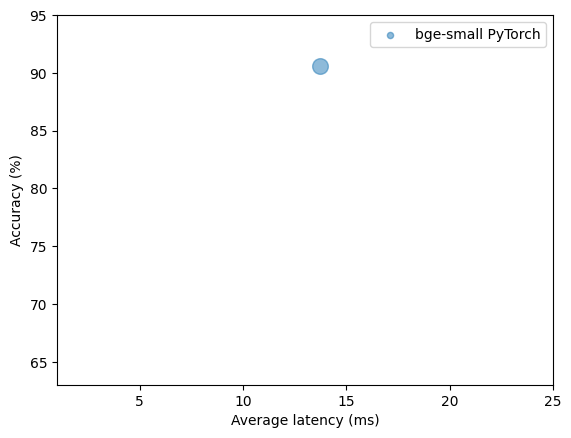

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient="index")

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                alpha=0.5,
                s=df_opt["size_mb"],
                label=idx,
                marker="$\u25CC$",
            )
        else:
            plt.scatter(
                df_opt["time_avg_ms"],
                df_opt["accuracy"] * 100,
                s=df_opt["size_mb"],
                label=idx,
                alpha=0.5,
            )

    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(63, 95)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["bge-small PyTorch"]["time_avg_ms"] + 12)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


plot_metrics(perf_metrics, "bge-small")

## 4. Eval DistillBERT as refrence

In [ ]:
from transformers import pipeline

#hide_output
finetuned_model = "distilbert-base-uncased-finetuned-sst-2-english"
pipe = pipeline("text-classification", model=finetuned_model)

In [ ]:
query = "that loves its characters and communicates something rather beautiful about human nature"
latencies = []

# Warmup
for _ in range(10):
    _ = pipe(query)[0]["label"]
    # Timed run
for _ in range(100):
    start_time = perf_counter()
    _ = pipe(query)[0]["label"]
    latency = perf_counter() - start_time
    latencies.append(latency)
# Compute run statistics
time_avg_ms = 1000 * np.mean(latencies)
time_std_ms = 1000 * np.std(latencies)
print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")

Average latency (ms) - 21.56 +\- 1.87


In [ ]:
metrics = {}
metrics["distillbert PyTorch"] = {"size_mb": 268} # 67M parameter in fp32
metrics["distillbert PyTorch"].update({"accuracy": 0.909}) # On SST-2 validation data
metrics["distillbert PyTorch"].update({"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms})

<ipython-input-10-cb0e686d654d>:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


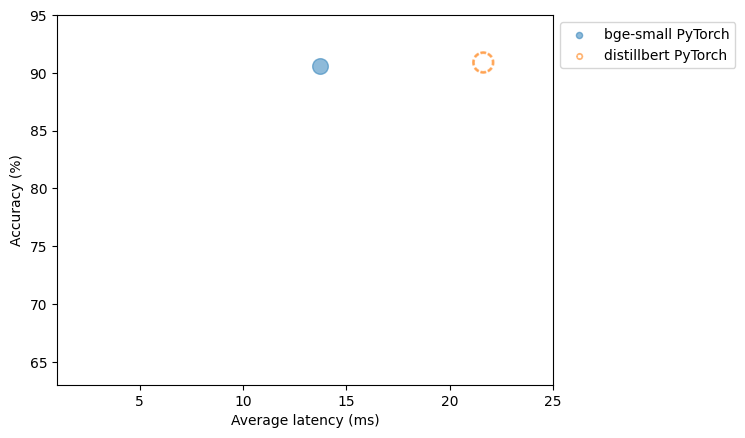

In [ ]:
perf_metrics.update(metrics)
plot_metrics(perf_metrics, "distillbert PyTorch")

## 5. Compressing further with Optimum ONNX and TensorrtExecutionProvider

In [ ]:
#@title We'll be using Optimum's ONNX Runtime support with `CUDAExecutionProvider` [because it's fast while also supporting dynamic shapes](https://github.com/huggingface/optimum-benchmark/tree/main/examples/fast-mteb#notes)

!pip install optimum[onnxruntime-gpu]

In [ ]:
#@title [`optimum-cli`](https://huggingface.co/docs/optimum/onnxruntime/usage_guides/optimization#optimizing-a-model-during-the-onnx-export) makes it extremely easy to export a model to ONNX and apply SOTA graph optimizations / kernel fusions

!optimum-cli export onnx \
  --model moshew/bge-small-en-v1.5_setfit-sst2-english \
  --task feature-extraction \
  --optimize O4 \
  --device cuda \
  bge_auto_opt_O4 # output folder

In [ ]:
onnx_path = Path("onnx")

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path

    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def compute_accuracy(self):
        preds = []
        chunk_size = 100
        for i in tqdm(range(0, len(self.dataset["text"]), chunk_size)):
            preds.extend(self.model.predict(self.dataset["text"][i : i + chunk_size]))
        labels = self.dataset["label"]
        accuracy = metric.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
        return accuracy

In [ ]:
#@title Based on the example given in [BAAI/bge-base-en-v1.5](https://huggingface.co/BAAI/bge-base-en-v1.5#using-huggingface-transformers)
import time
import torch
from transformers import AutoTokenizer
from optimum.onnxruntime import ORTModelForFeatureExtraction

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('/content/bge_auto_opt_O4')
#ort_model = ORTModelForFeatureExtraction.from_pretrained('/content/bge_auto_opt_O4', provider="CUDAExecutionProvider")
ort_model = ORTModelForFeatureExtraction.from_pretrained('/content/bge_auto_opt_O4', provider="TensorrtExecutionProvider")

ort_model.save_pretrained(onnx_path)
tokenizer.save_pretrained(onnx_path)


EP Error /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1193 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_tensorrt.so with error: libnvinfer.so.8: cannot open shared object file: No such file or directory
 when using ['TensorrtExecutionProvider', 'CUDAExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.


('onnx/tokenizer_config.json',
 'onnx/special_tokens_map.json',
 'onnx/vocab.txt',
 'onnx/added_tokens.json',
 'onnx/tokenizer.json')

In [ ]:
from setfit.exporters.utils import mean_pooling
from sklearn.linear_model import LogisticRegression


class OnnxSetFitModel_1:
    def __init__(self, ort_model, tokenizer, model_head):
        self.ort_model = ort_model
        self.tokenizer = tokenizer
        self.model_head = model_head

    def predict(self, inputs):
        encoded_inputs = self.tokenizer(
            inputs, padding=True, truncation=True, return_tensors="pt"
        ).to("cuda")

        outputs = self.ort_model(**encoded_inputs)
        embeddings = mean_pooling(
            outputs["last_hidden_state"], encoded_inputs["attention_mask"]
        )
        return self.model_head.predict(torch.Tensor.cpu(embeddings))

    def __call__(self, inputs):
        return self.predict(inputs)

In [ ]:
model = SetFitModel.from_pretrained("moshew/bge-small-en-v1.5_setfit-sst2-english")
onnx_setfit_model = OnnxSetFitModel_1(ort_model, tokenizer, model.model_head)
onnx_setfit_model(test_dataset["text"][:2])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


array([0, 0])

In [ ]:
pb = OnnxPerformanceBenchmark(
    onnx_setfit_model,
    test_dataset,
    "bge-small_TensorRT (optimum onnx)",
    model_path="onnx/model.onnx",
)

Model size (MB) - 65.93


  0%|          | 0/9 [00:00<?, ?it/s]

Accuracy on test set - 0.906
Average latency (ms) - 2.55 +\- 0.78


<ipython-input-10-cb0e686d654d>:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


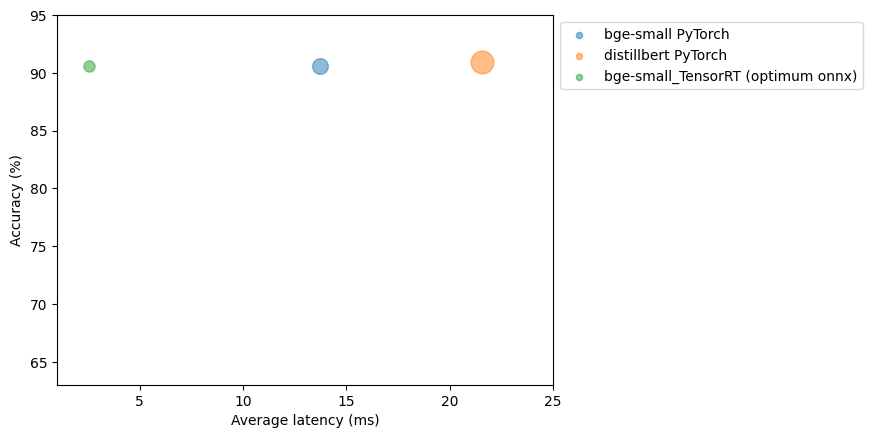

In [ ]:
perf_metrics.update(pb.run_benchmark())
plot_metrics(perf_metrics, "bge-small (optimum onnx)")